In [37]:
import itertools
import numpy as np
import pandas as pd
import pickle
import pydotplus
import seaborn as sns
import sys
import time
import warnings
import zipfile

from collections import (Counter,)
from imblearn.under_sampling \
    import (RandomUnderSampler,
            ClusterCentroids,
            TomekLinks,)
from imblearn.over_sampling \
    import (RandomOverSampler,
            SMOTE,)
from io import (StringIO,)
from IPython.display import (Image,)
from matplotlib import (pyplot as plt,)
from mlxtend.classifier import (StackingClassifier,)
from scipy import (stats,)
from scipy.cluster import (hierarchy as sch,)
from sklearn.cluster \
    import (KMeans,
            AgglomerativeClustering,)
from sklearn.datasets import (make_moons,)
from sklearn.decomposition import (PCA,) 
from sklearn.ensemble \
    import (AdaBoostClassifier,
            BaggingClassifier,
            ExtraTreesClassifier,
            GradientBoostingClassifier,
            RandomForestClassifier,
            VotingClassifier,)
from sklearn.feature_selection \
    import (chi2,
            f_regression,
            f_classif,
            RFE,
            SelectFromModel,
            SelectKBest,
            SelectPercentile,)
from sklearn.linear_model \
    import (Lasso,
            LogisticRegression,
            LinearRegression,
            Ridge,)
from sklearn.metrics \
    import (accuracy_score,
            auc,
            classification_report,
            confusion_matrix,
            f1_score,
            precision_score,
            precision_recall_fscore_support as error_metric,
            r2_score,
            recall_score,
            roc_auc_score,
            roc_curve,)
from sklearn.model_selection \
    import (GridSearchCV,
            RandomizedSearchCV,
            train_test_split,)
from sklearn.multiclass import (OneVsRestClassifier,)
from sklearn.pipeline import (make_pipeline,)
from sklearn.preprocessing \
    import (LabelEncoder,
            MinMaxScaler,
            StandardScaler,)
from sklearn.svm \
    import (LinearSVC,
            LinearSVC,
            SVC,)
from sklearn.tree \
    import (DecisionTreeClassifier,
            DecisionTreeRegressor,)
from xgboost import (XGBClassifier,)

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def plot_auc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def get_scores(model, X_test, y_test,):
    y_pred = model.best_estimator_.predict(X_test,)
    print("Accuracy: {0}".format(accuracy_score(y_test, y_pred,)))
    print("\n")
    print("Recall: {0}".format(recall_score(y_test, y_pred,)))
    print("Precision: {0}".format(precision_score(y_test, y_pred,)))
    print("F1 Score: {0}".format(f1_score(y_test, y_pred,)))
    print("\n")
    print("ROC AUC: {0}".format(roc_auc_score(y_test, y_pred,)))
    print("\n")
    print("Confusion Matrix: \n{0}".format(confusion_matrix(y_test, y_pred,)))
    print("\n")
    print("Classification Report: \n{0}".format(classification_report(y_test, y_pred,)))
    plot_auc(y_test, y_pred)
    
def get_results_df(gscv_model,):
    # Creating a dictionary out of the GridSearchCV results
    results_dict = {}
    results = gscv_model.cv_results_
    
    for key in results.keys():
        if type(results[key]) == np.ndarray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == np.ma.core.MaskedArray:
            results_dict[key] = list(results[key])
            
        elif type(results[key]) == list:
            pass
            # Accidentally wrote code for something that already exists.
            # Might as well keep it for later
#             if type(results[key][0]) == dict:
#                 cumulated_dict = {}
#                 for dict_key in results[key][0].keys():
#                     cumulated_dict[f'{key}_{dict_key}'] = []
#                 for dict_key in results[key][0].keys():
#                     for entry in results[key]:
#                         cumulated_dict[f'{key}_{dict_key}'].append(str(entry[dict_key]))
#                 for dict_key in results[key][0].keys():
#                     results_dict[f'{key}_{dict_key}'] = cumulated_dict[f'{key}_{dict_key}']
        else:
            print("Unkown type encountered")
        
    return_df = pd.DataFrame(data=results_dict,)
    
    if return_df.isnull().sum().max() > 0:
        print("Incorrect model training values have been omitted")
        print("{0} values".format(return_df.isnull().sum().max()))
    return_df.dropna(axis=0, inplace=True)
    
    return return_df

def train_model(model, hyperparameters, scoring_, filename):
    gscv_model = GridSearchCV(model, hyperparameters, cv=10, verbose=0, scoring=scoring_, n_jobs=-1, return_train_score=True,)

    try:
        with open(file_name, 'rb') as handle:
            gscv_model = pickle.load(handle)
        print("Found trained model file with same name. Loading it instead.")
    except:
        start_time = time.time()

        gscv_model.fit(X_train, y_train,)

        time_taken_s = np.around(time.time()-start_time, decimals=2,)
        time_taken_m = time_taken_s/60  
        print('Total Time taken = {0} seconds \nIn minutes: {1}'.format(time_taken_s, time_taken_m,))

        with open(file_name, 'wb') as handle:
            pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    return gscv_model

def get_data(data_type_code):
    
    X_train, X_test, y_train, y_test = ["", "", "", "",]
    
    # Unmodified Data
    if data_type_code==1:
        X, y = pd.read_csv("X_cleaned.csv").iloc[:,1:], pd.read_csv("y_cleaned.csv").iloc[:,1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y,)
    
    # Undersample Data
    elif data_type_code==2:
#         X, y = pd.read_csv("X_undersampled.csv").iloc[:,1:], pd.read_csv("y_undersampled.csv").iloc[:,1]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y,)
        X_train = pd.read_csv('X_train_undersampled.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_undersampled.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_undersampled.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_undersampled.csv').iloc[:, 1]
    
    # Oversampled Data
    elif data_type_code==3:
        X_train = pd.read_csv('X_train_oversampled.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_oversampled.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_oversampled.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_oversampled.csv').iloc[:, 1]
    
    # SMOTE Data
    elif data_type_code==4:
        X_train = pd.read_csv('X_train_smote.csv').iloc[:, 1:]
        X_test = pd.read_csv('X_test_smote.csv').iloc[:, 1:]
        y_train = pd.read_csv('y_train_smote.csv').iloc[:, 1]
        y_test = pd.read_csv('y_test_smote.csv').iloc[:, 1]
    
    else:
        raise Exception('Wrong Data Code')
        

    return [X_train, X_test, y_train, y_test]
    

$Logistic$ $Regression$

Found trained model file with same name. Loading it instead.
For unmodified data :
y_train: 35385
	Class 0: 34866, Class 1: 519
y_test: 15166
	Class 0: 14944, Class 1: 222
Incorrect model training values have been omitted
720 values
Accuracy: 0.8377950679150732


Recall: 0.6126126126126126
Precision: 0.054183266932270914
F1 Score: 0.09956076134699854


ROC AUC: 0.7268764347859636


Confusion Matrix: 
[[12570  2374]
 [   86   136]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     14944
           1       0.05      0.61      0.10       222

    accuracy                           0.84     15166
   macro avg       0.52      0.73      0.51     15166
weighted avg       0.98      0.84      0.90     15166



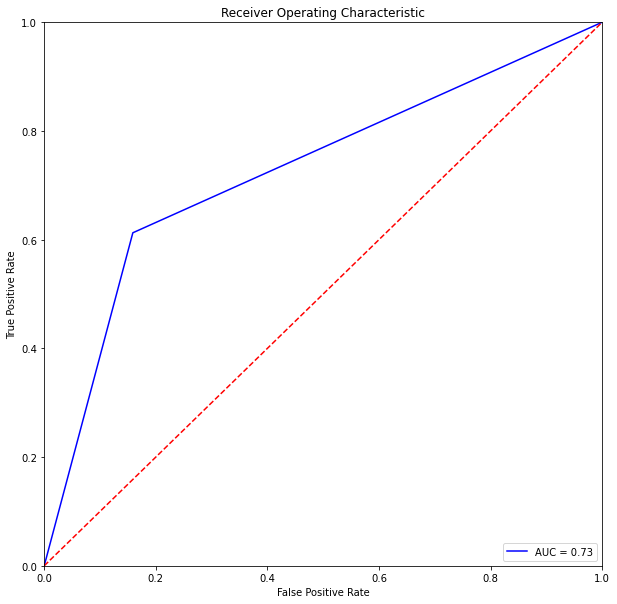

Found trained model file with same name. Loading it instead.
For undersampled data :
y_train: 1038
	Class 0: 519, Class 1: 519
y_test: 15166
	Class 0: 14944, Class 1: 222
Incorrect model training values have been omitted
720 values
Accuracy: 0.024858235526836345


Recall: 0.990990990990991
Precision: 0.014659825414806423
F1 Score: 0.028892245058769455


ROC AUC: 0.5007484398209773


Confusion Matrix: 
[[  157 14787]
 [    2   220]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.01      0.02     14944
           1       0.01      0.99      0.03       222

    accuracy                           0.02     15166
   macro avg       0.50      0.50      0.02     15166
weighted avg       0.97      0.02      0.02     15166



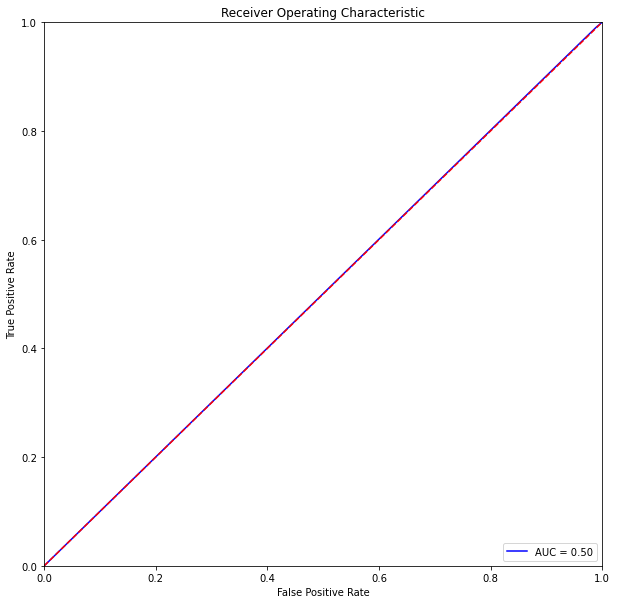

Found trained model file with same name. Loading it instead.
For oversampled data :
y_train: 69756
	Class 0: 34878, Class 1: 34878
y_test: 15166
	Class 0: 14932, Class 1: 234
Accuracy: 0.031583805881577214


Recall: 0.9658119658119658
Precision: 0.01516269708151627
F1 Score: 0.02985666160248365


ROC AUC: 0.49137772145406755


Confusion Matrix: 
[[  253 14679]
 [    8   226]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.02      0.03     14932
           1       0.02      0.97      0.03       234

    accuracy                           0.03     15166
   macro avg       0.49      0.49      0.03     15166
weighted avg       0.95      0.03      0.03     15166



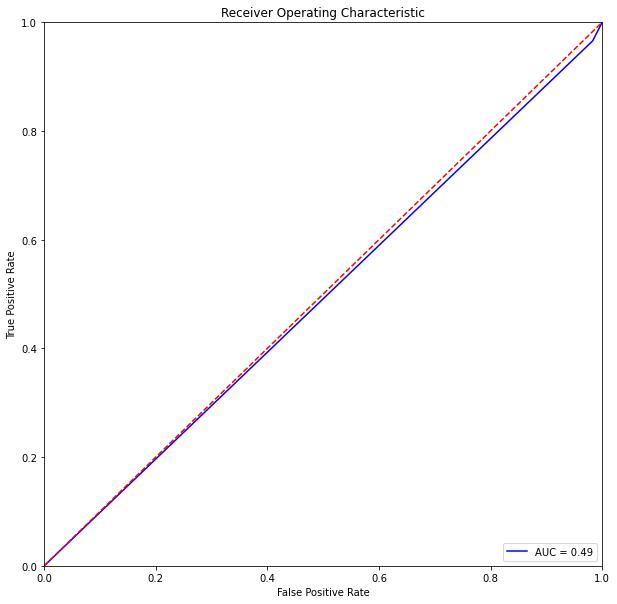

Found trained model file with same name. Loading it instead.
For smote data :
y_train: 69756
	Class 0: 34878, Class 1: 34878
y_test: 15166
	Class 0: 14932, Class 1: 234
Accuracy: 0.23961492812870896


Recall: 0.9145299145299145
Precision: 0.018250042640286544
F1 Score: 0.03578595317725753


ROC AUC: 0.571784110760805


Confusion Matrix: 
[[ 3420 11512]
 [   20   214]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.23      0.37     14932
           1       0.02      0.91      0.04       234

    accuracy                           0.24     15166
   macro avg       0.51      0.57      0.20     15166
weighted avg       0.98      0.24      0.37     15166



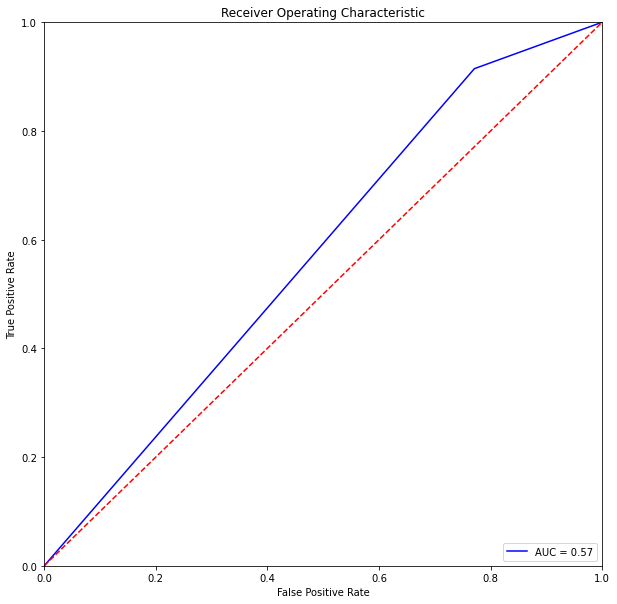

In [3]:
results = {}

for data_code, code_string in zip(range(1,5), ['unmodified', 'undersampled', 'oversampled', 'smote']):
    
    X_train, X_test, y_train, y_test = get_data(data_code)
    
    model = LogisticRegression(random_state=4,)

    hyperparameters = {
#         'penalty': ['l1', 'l2', 'elasticnet', 'None'],
#         'C': [0.05, 0.25, 0.7, 1, 2,],
        'class_weight': ['balanced', {0:1, 1:5,}],
#         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter':[1000, 5000,],
        'n_jobs': [-1],
#         'l1_ratio': [0.25, 0.5, 0.75,],
    }

    scoring = "roc_auc"

    file_name = f'trained_model_logreg_{data_code}{code_string}.pickle'

    gscv_model = train_model(model, hyperparameters, scoring, file_name,)
    
    print("="*60)
    print(f"For {code_string} data :")
    print(f'y_train: {len(y_train)}')
    print('\tClass 0: {0}, Class 1: {1}'.format(len(y_train[y_train==0]), len(y_train[y_train==1]),))
    
    print(f'y_test: {len(y_test)}')
    print(f'\tClass 0: {len(y_test[y_test==0])}, Class 1: {len(y_test[y_test==1])}')
    print("="*60)
    
    results[f'logreg_{code_string}'] = get_results_df(gscv_model)
#     results_df = get_results_df(gscv_model)
#     print(results_df.head(4).T)
#     print(results_df.sort_values(by='rank_test_score', ascending=True).iloc[0,:].T)
    get_scores(gscv_model, X_test, y_test,)

In [4]:
X_train

,Agency,Agency Type,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,7,1,1,14,100,20.000000,0.000000,36
1,7,1,1,26,79,57.000000,0.000000,36
2,2,0,9,6,79,17.550000,4.390000,33
3,7,1,1,9,100,20.000000,0.000000,38
4,9,0,24,12,72,26.000000,9.100000,59
...,...,...,...,...,...,...,...,...
69751,4,1,13,7,56,25.532909,10.440541,25
69752,7,1,1,34,36,21.527789,0.000000,37
69753,2,0,9,93,79,46.138716,11.539679,22
69754,6,0,9,39,94,58.388250,1.504470,37


In [5]:
X_train, X_test, y_train, y_test = get_data(1)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
df = X
df['Target'] = y
df

,Agency,Agency Type,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Target
23251,2,0,9,3,79,13.5,3.38,25,0
22214,7,1,10,174,82,15.0,0.00,36,0
7080,6,1,16,49,65,89.1,53.46,68,0
29406,7,1,1,12,96,112.0,0.00,50,0
13244,1,0,24,137,34,61.0,21.35,118,0
...,...,...,...,...,...,...,...,...,...
25591,9,0,8,49,63,18.0,6.30,42,0
33576,7,1,1,101,88,20.0,0.00,33,0
25114,9,0,8,17,17,26.0,9.10,29,0
33624,6,1,16,63,95,39.6,23.76,31,0


In [6]:
positive = df[df['Target']==1]
negative = df[df['Target']==0]

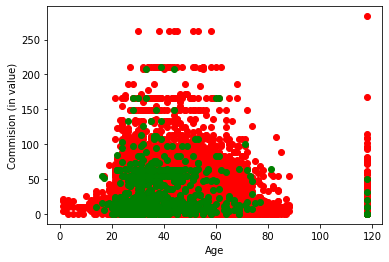

In [8]:
col_1 = 'Age'
col_2 = 'Commision (in value)'

plt.scatter(negative[col_1], negative[col_2], color='r')
plt.scatter(positive[col_1], positive[col_2], color='g')
plt.ylabel(col_2)
plt.xlabel(col_1)
plt.show()

In [63]:
X_train, X_test, y_train, y_test = get_data(1)

X_train['target'] = y_train.copy()
X_train.drop(X_train[X_train['Age']>100].index, axis=0, inplace=True)
y_train = X_train['target'].copy()
X_train.drop('target', axis=1, inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train,)
X_test_scaled = scaler.transform(X_test,)

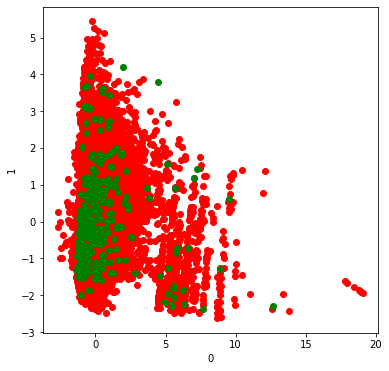

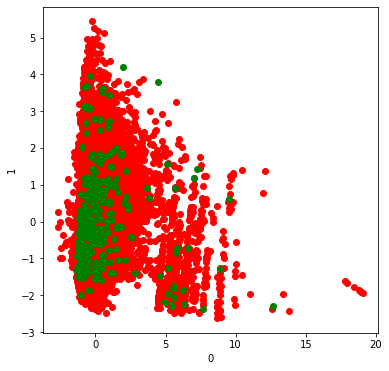

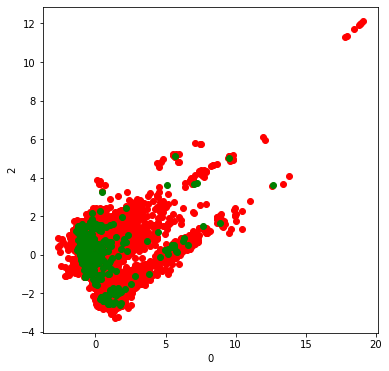

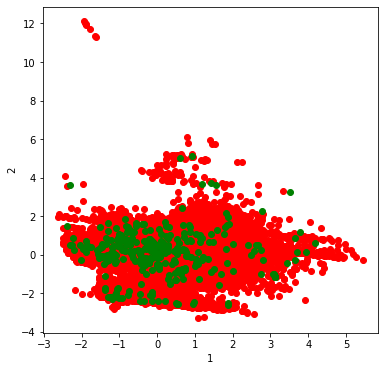

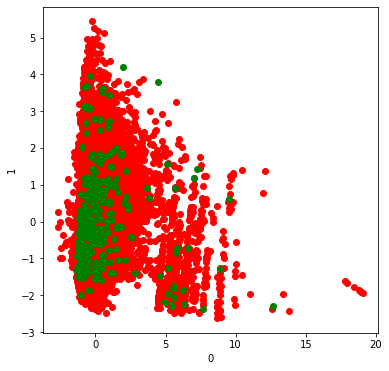

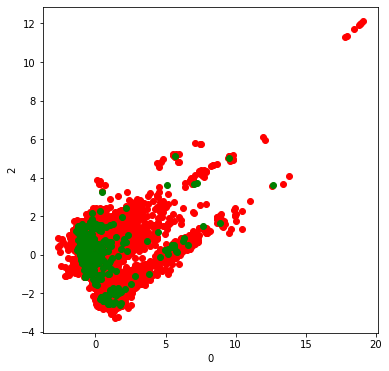

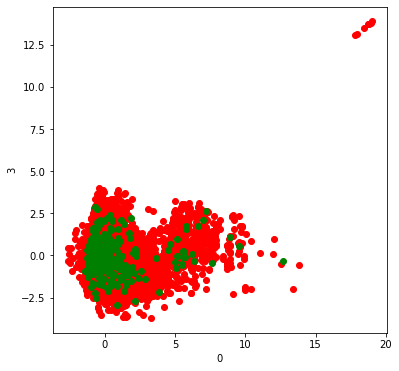

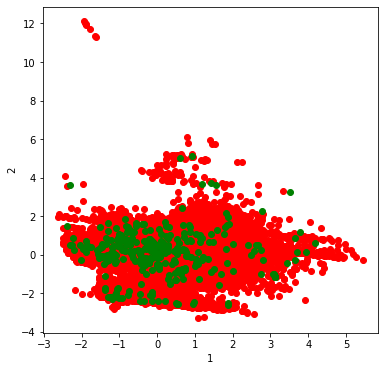

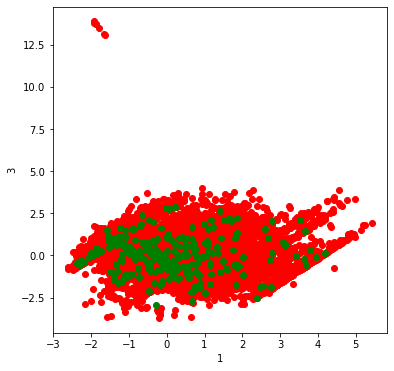

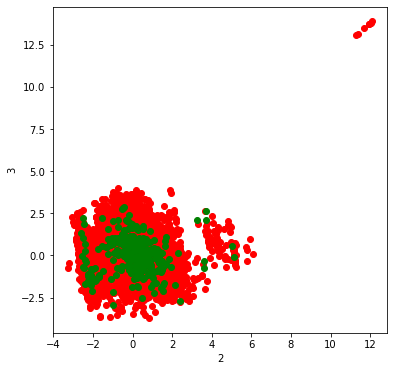

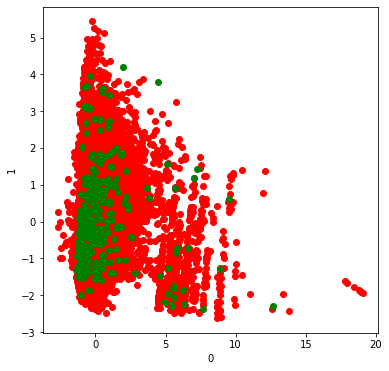

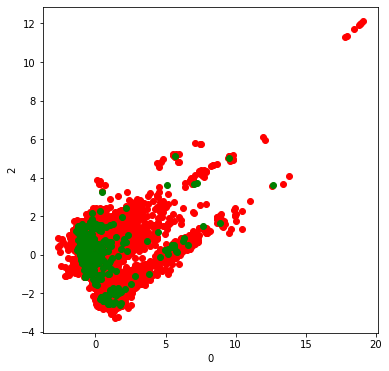

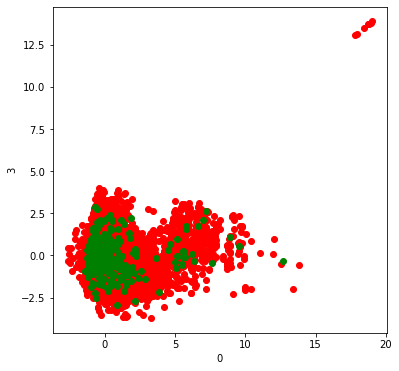

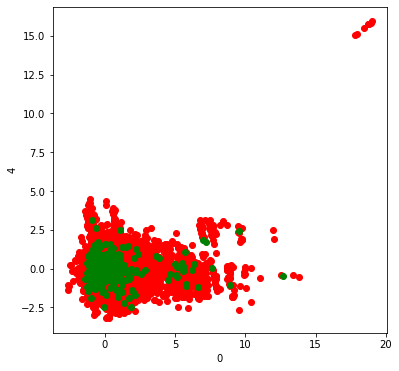

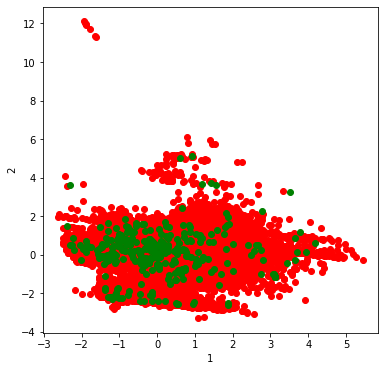

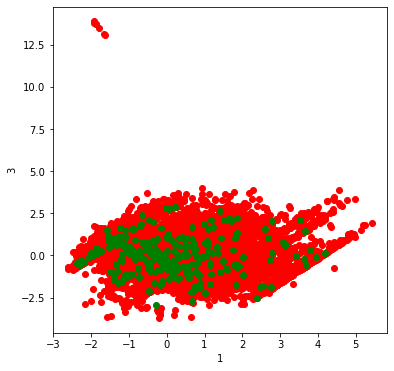

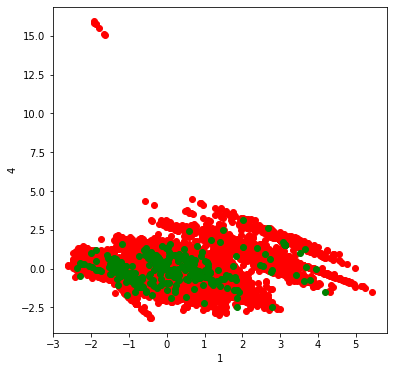

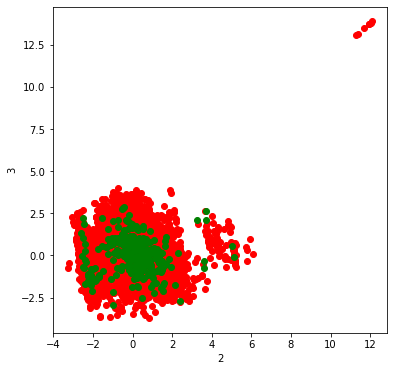

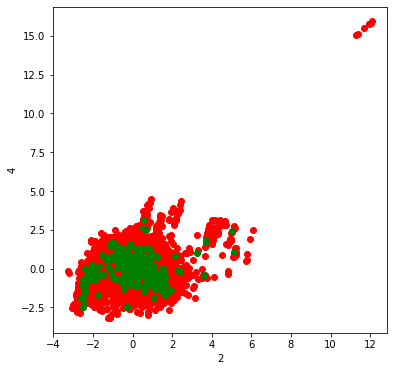

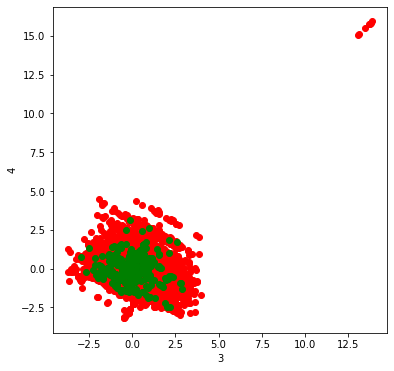

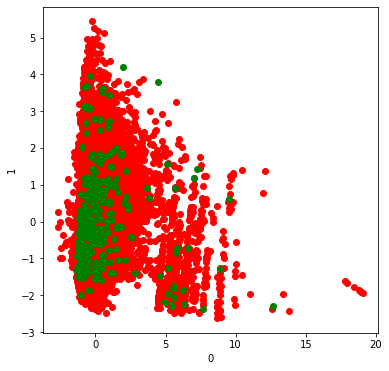

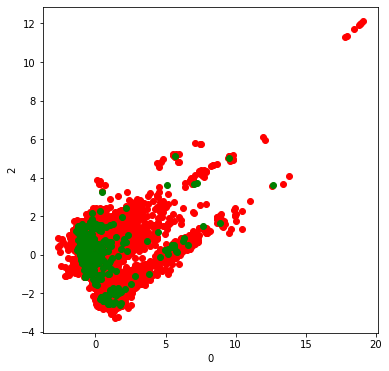

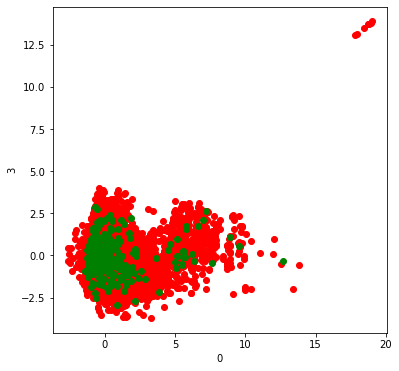

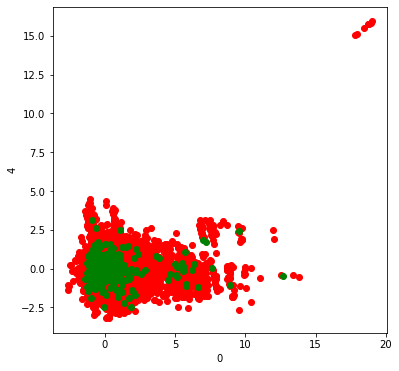

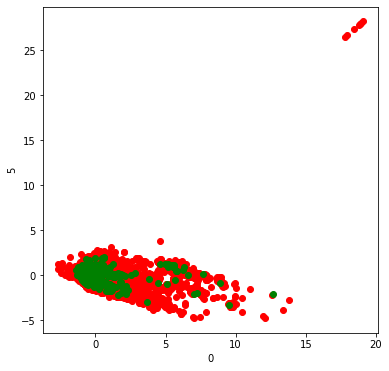

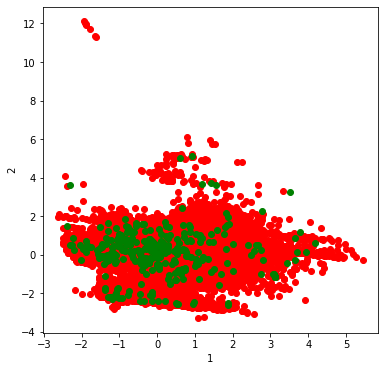

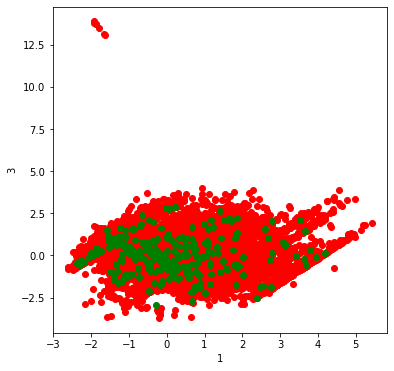

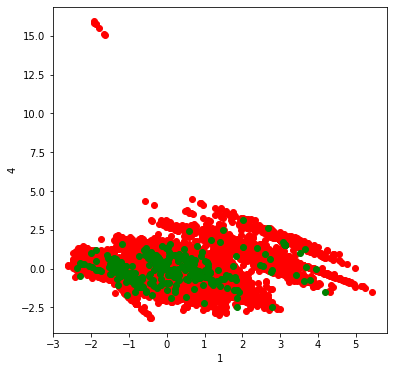

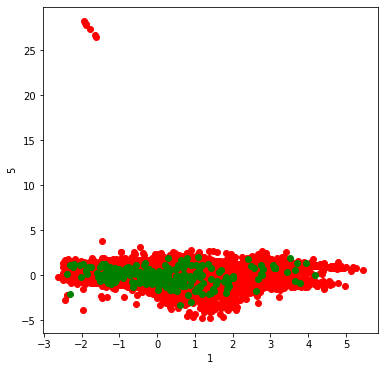

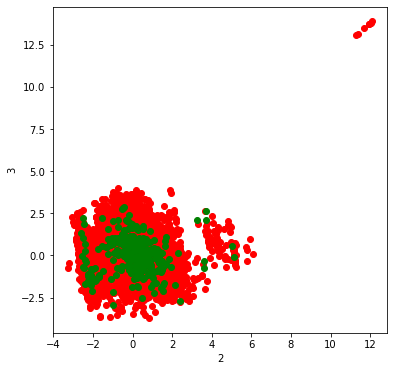

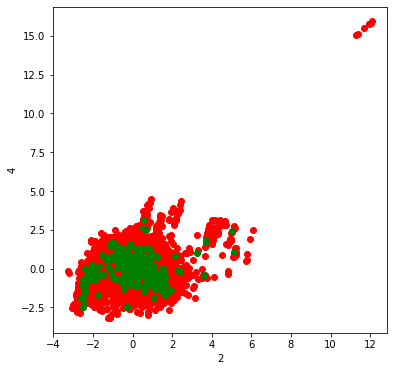

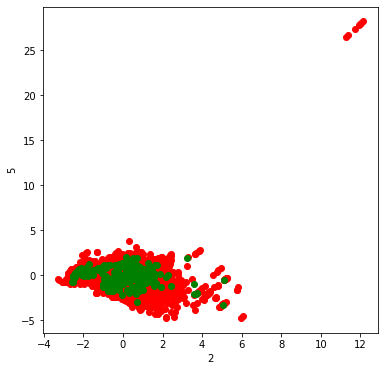

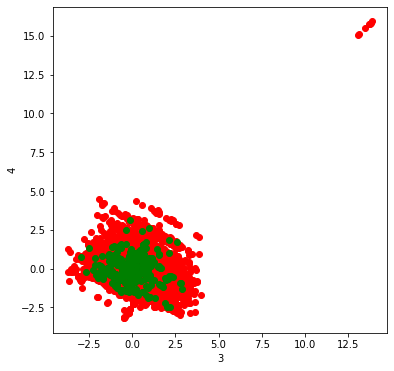

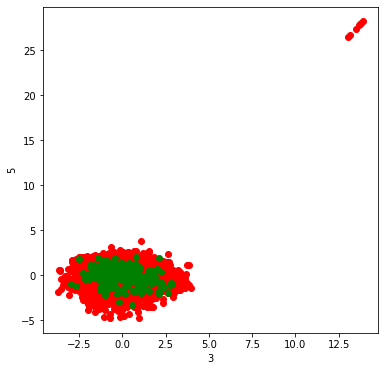

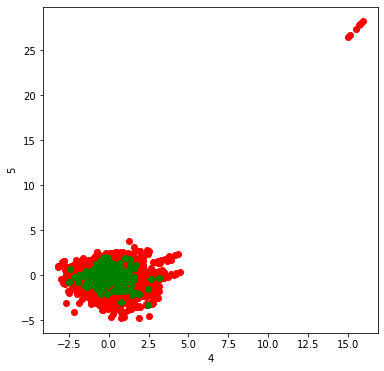

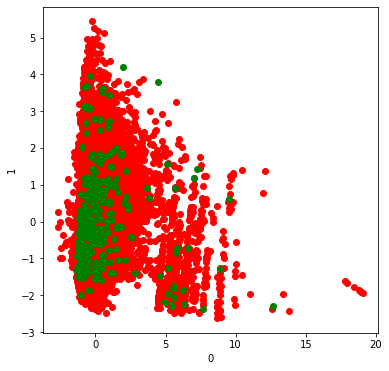

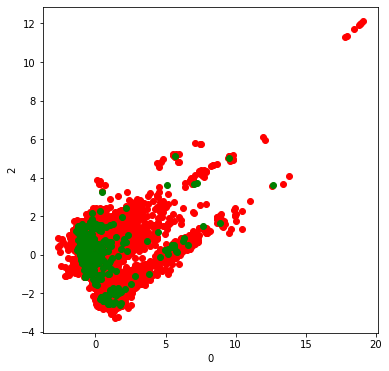

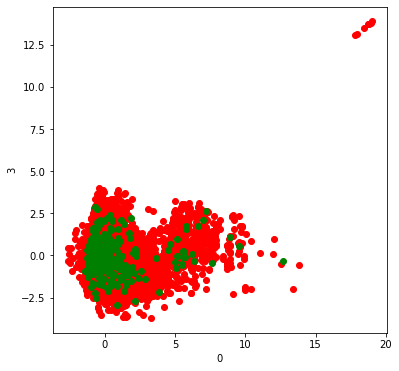

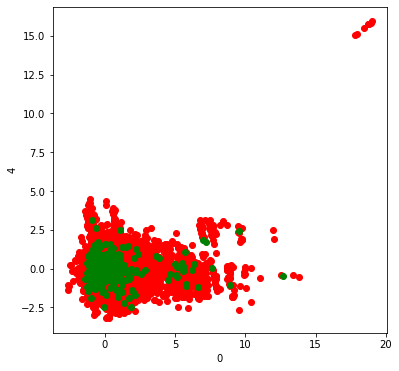

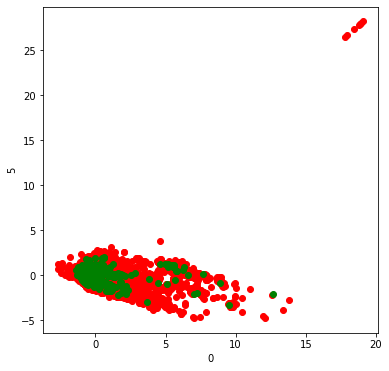

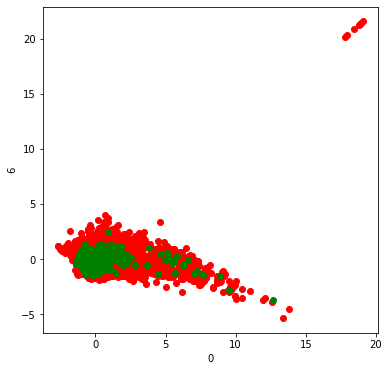

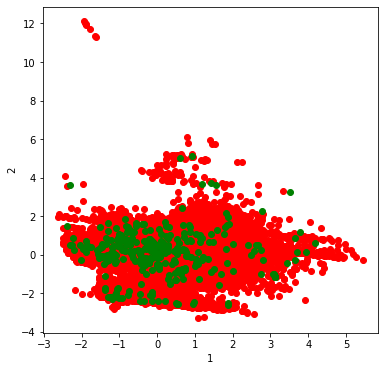

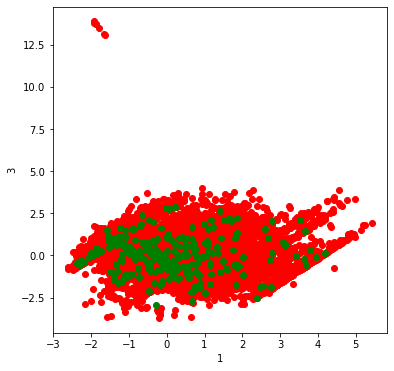

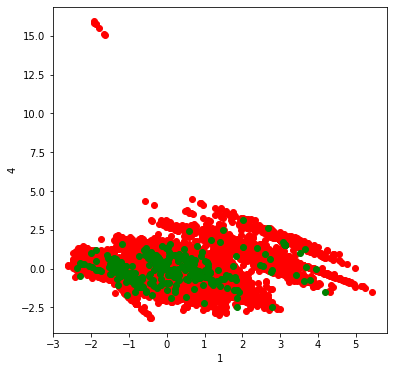

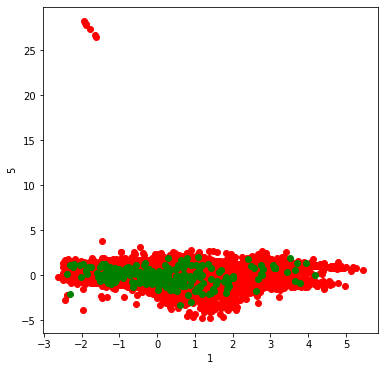

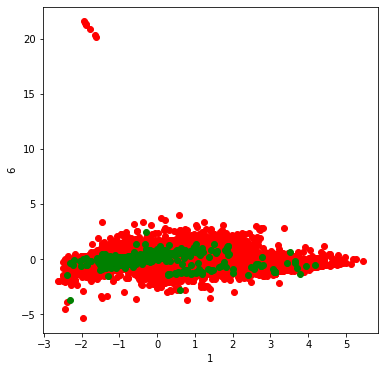

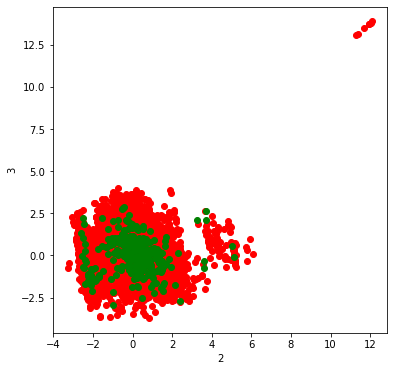

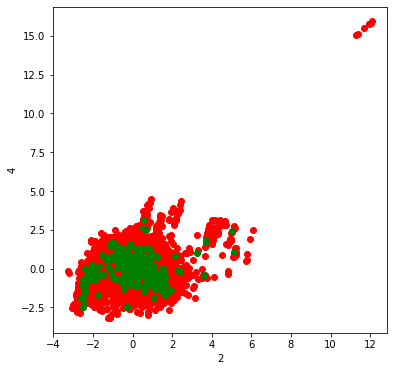

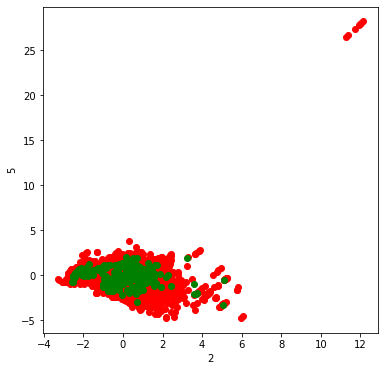

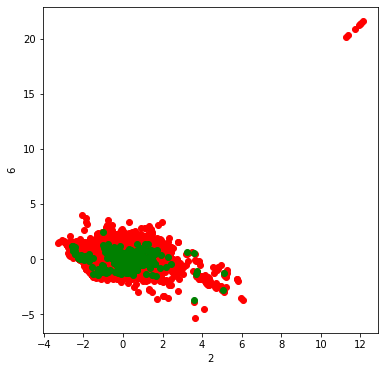

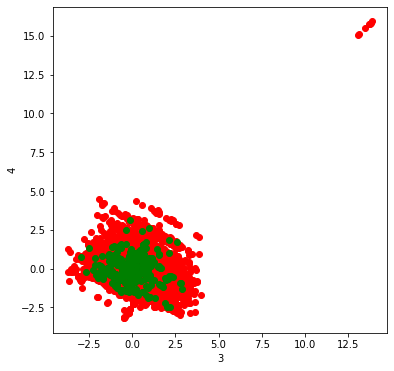

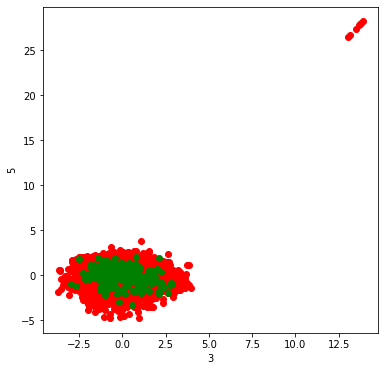

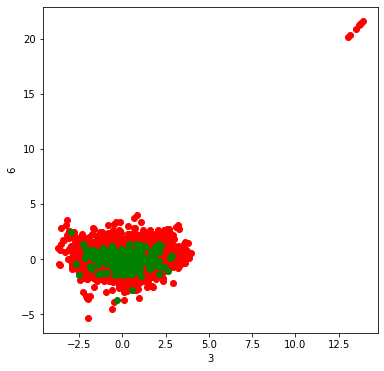

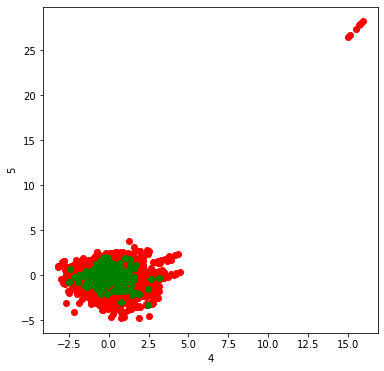

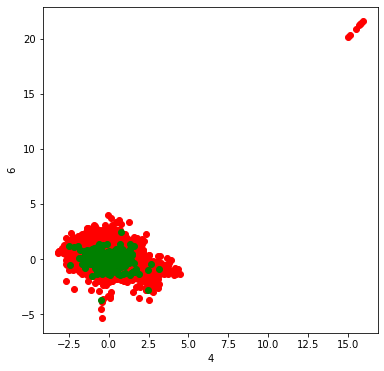

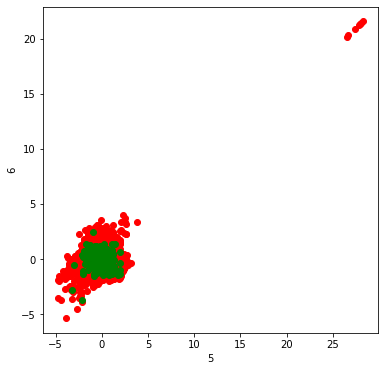

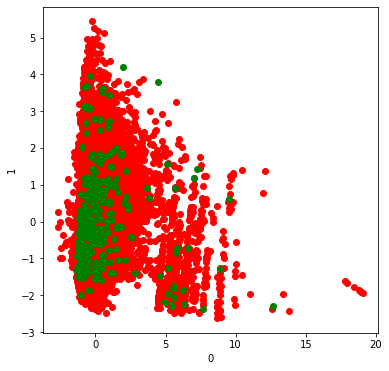

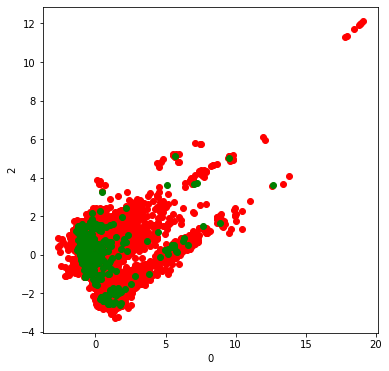

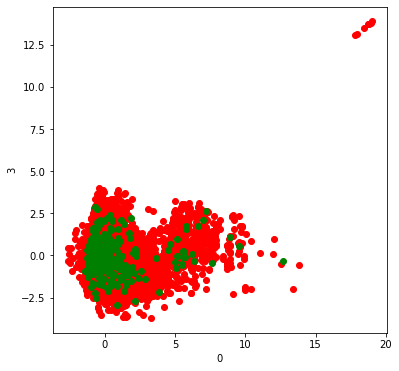

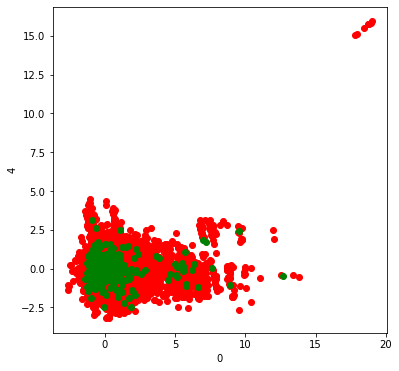

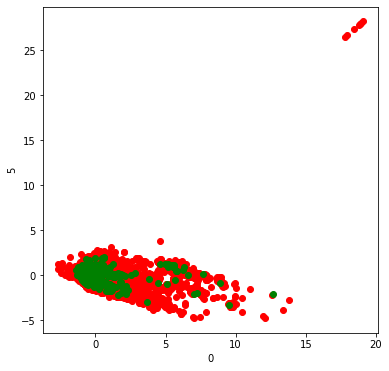

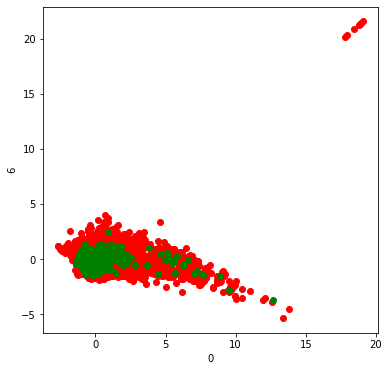

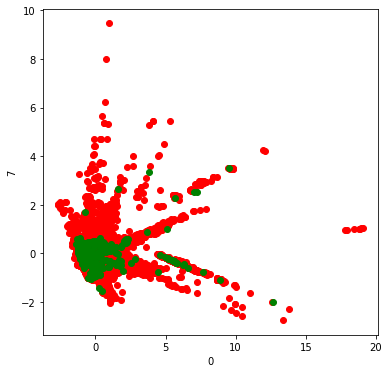

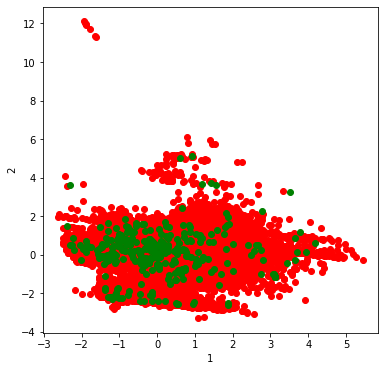

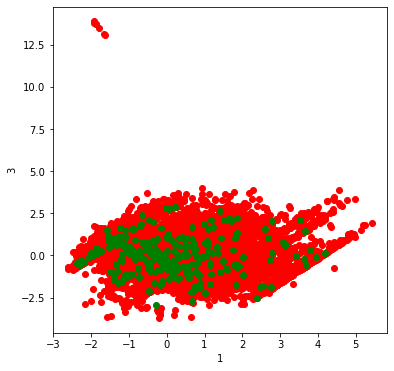

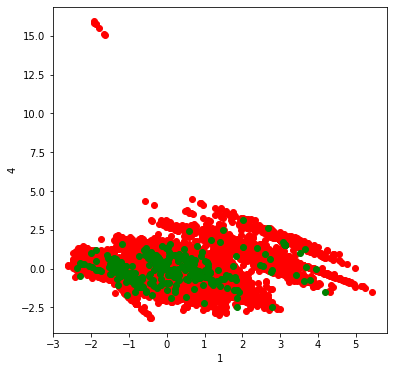

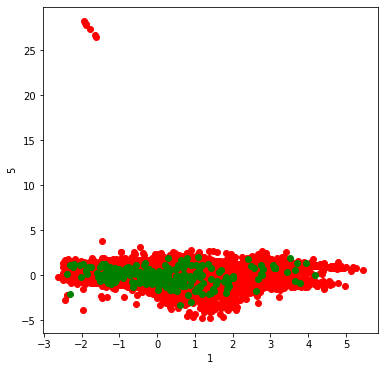

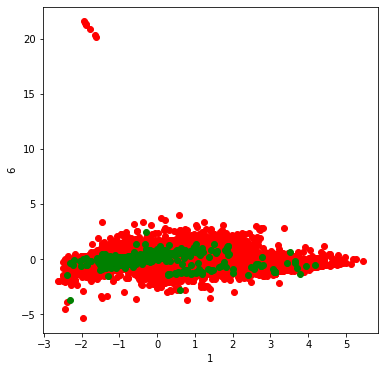

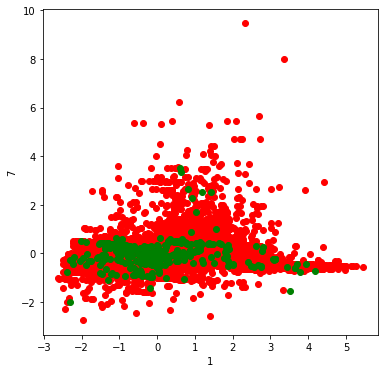

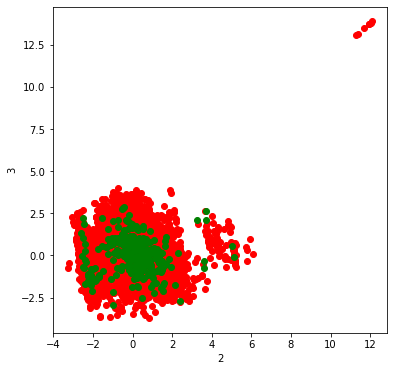

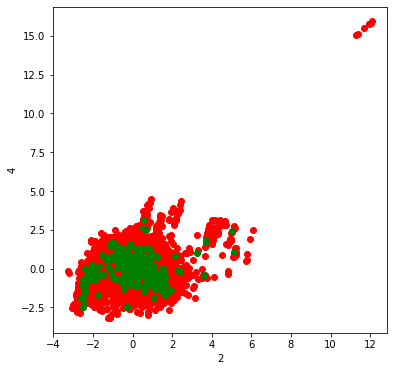

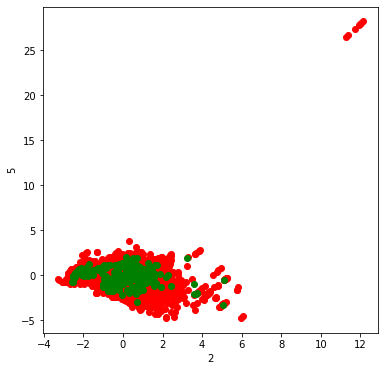

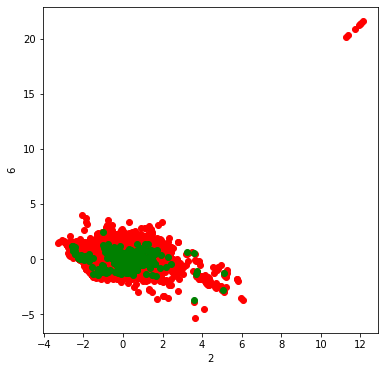

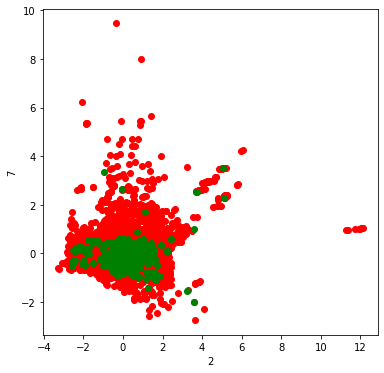

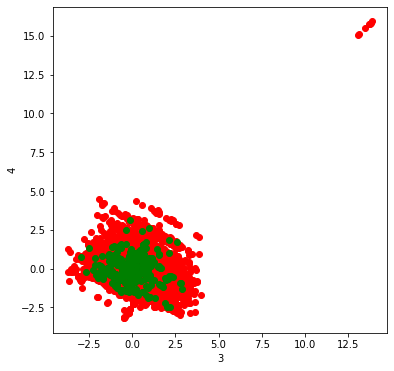

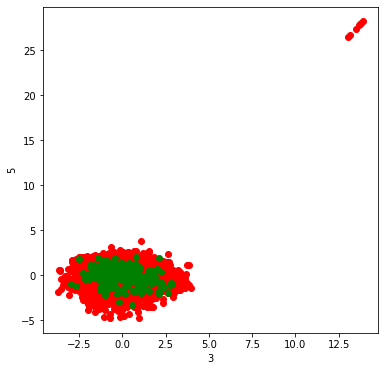

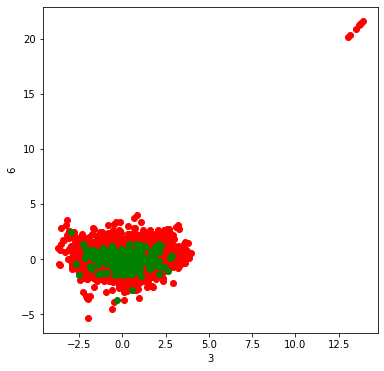

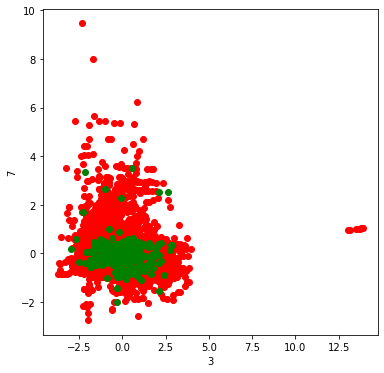

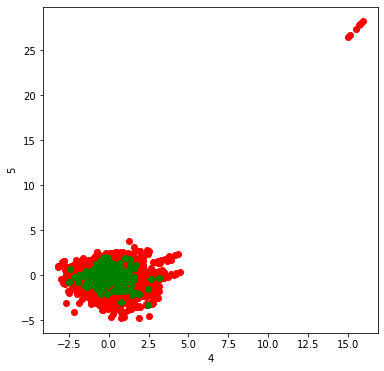

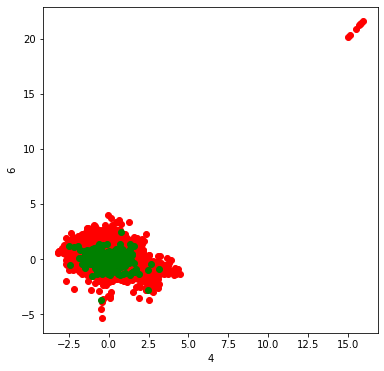

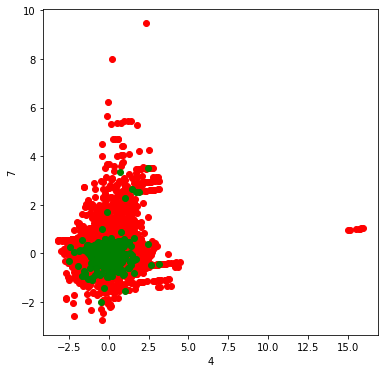

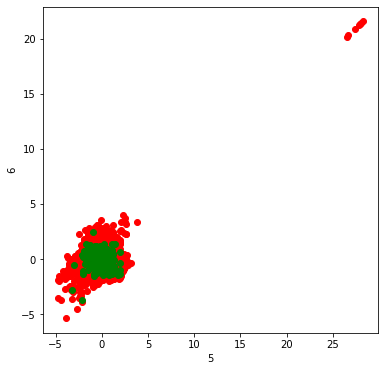

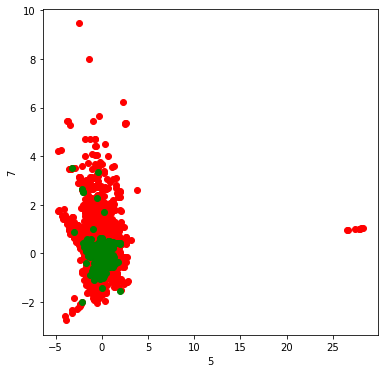

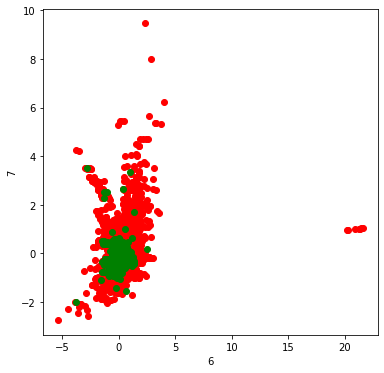

In [78]:
# components = 8

for components in range(2, 9):
    
    print("="*80)
    pca = PCA(n_components=components, random_state=4,)
    X_train_pca = pca.fit_transform(X_train_scaled, y_train,)
    X_test_pca = pca.transform(X_test_scaled,)

    my_df = pd.DataFrame(X_train_pca)
    my_df['target'] = y_train

    for i in list(itertools.combinations([i for i in range(0,components)], 2)):
        plt.figure(figsize=(6,6))
        plt.scatter(x=my_df[my_df['target']==0][i[0]], y=my_df[my_df['target']==0][i[1]], color='r')
        plt.scatter(x=my_df[my_df['target']==1][i[0]], y=my_df[my_df['target']==1][i[1]], color='g')
        plt.xlabel(i[0])
        plt.ylabel(i[1])
        plt.show()

$Scammers$

In [74]:
X_train.iloc[my_df[ my_df[5]>20 ].index]

,Agency,Agency Type,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
17701,13,0,22,4736,79,0.32,0.09,48
27269,13,0,22,4857,79,0.32,0.09,48
28142,13,0,22,4815,79,0.32,0.09,48
31069,13,0,22,4829,79,0.32,0.09,48
12082,13,0,22,4609,79,0.32,0.09,48
16796,13,0,22,4685,79,0.32,0.09,48
43741,13,0,22,4881,79,0.13,0.04,48
15325,13,0,22,4580,79,0.32,0.09,48


In [75]:
X_train.iloc[my_df[ my_df[3]>10 ].index]

,Agency,Agency Type,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
17701,13,0,22,4736,79,0.32,0.09,48
27269,13,0,22,4857,79,0.32,0.09,48
28142,13,0,22,4815,79,0.32,0.09,48
31069,13,0,22,4829,79,0.32,0.09,48
12082,13,0,22,4609,79,0.32,0.09,48
16796,13,0,22,4685,79,0.32,0.09,48
43741,13,0,22,4881,79,0.13,0.04,48
15325,13,0,22,4580,79,0.32,0.09,48
